# Importing Packages and Connecting to DB

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [4]:
import sys, os
import time;
import json;
from optparse import OptionParser
from cStringIO import StringIO;
from datetime import timedelta;

In [3]:
import sys, os
import pandas as pd
import psycopg2
from datetime import timedelta
from medinfo.dataconversion import FeatureMatrixFactory as fmf;

def connectToDB():
    '''
    Connects to Database, requires password
    '''

    dsn_database = "medinfo"
    dsn_hostname = "healthrex-db.cwyfvxgvic6c.us-east-1.rds.amazonaws.com"
    dsn_port = "5432"
    dsn_uid = "jonc101"
    dsn_pwd = raw_input("Enter the database password: ")


    try:
        conn_string = "host='"+dsn_hostname+"' port="+dsn_port+" dbname='"+dsn_database+"' user='"+dsn_uid+"' password='"+dsn_pwd+"'"
        print "Connecting to database\n  ->%s" % (conn_string)
        conn=psycopg2.connect(conn_string)
        print "Connected!\n"

    except:
        print "Unable to connect to the database."

    cursor = conn.cursor()
    return cursor, conn

cursor, conn = connectToDB()

/home/ec2-user/.local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Enter the database password: 3picFai1
Connecting to database
  ->host='healthrex-db.cwyfvxgvic6c.us-east-1.rds.amazonaws.com' port=5432 dbname='medinfo' user='jonc101' password='3picFai1'
Connected!



### Human Authored Order Set Validation Set
Input:

1) matrix of responses/what actually happens 24hrs after for all patient_items

2) patient_items we want to compare to from the test set of our algorithm

3) columns of responses that are comparable to order sets, where default_recommend + analysis status = 1

Output:
f1, precision, accuracy, recall

Objectives.
1) Obtain all patient items that are part of order sets

2) figure out what order sets they were a part of

3) for each order set, create a vector of responses that represent what the order set says to order

4) create a matrix of responses from this order set

5) calculate f1 and f2 score to real response variables (with filtered out clinical items as appropriate) for baseline



## Obtaining all of the patient_item_ids that are from order sets

In [4]:
loadingdata=True

In [39]:
#load in data
data_dir = '/home/ec2-user/cs230/scripts/HumanBaseline/Actual_Final_Files/XY_data/'
fname = data_dir+'y_dev.txt'
y_dev = pd.read_csv(fname, sep = '\t')
fname = data_dir + 'y_test.txt'
y_test = pd.read_csv(fname, sep = '\t')
response_matrix = pd.concat([y_dev, y_test])

In [40]:
fname = data_dir+'x_dev.txt'
x_dev = pd.read_csv(fname, usecols=[0], sep = '\t')
fname = data_dir + 'x_test.txt'
x_test = pd.read_csv(fname, usecols=[0], sep = '\t')
p_id_column = pd.concat([x_dev, x_test])

In [41]:
response_matrix["patient_item_id"] = patientitemids_from_data

In [42]:
response_matrix.shape

(60912, 1453)

In [43]:
len(y_dev) + len(y_test)

60912

In [44]:
patientitemids_from_data = response_matrix["patient_item_id"]

need to change cell below based on new real columns

In [22]:
#create response columns to use for comparison later NEED TO CHANGE THIS
response_vars = []
f = open('/home/ec2-user/cs230/scripts/matrix/response_vars_FINAL_0307.txt', 'r')
for line in f:
    response_vars.append(line.split('\n')[0])
f.close()
len(response_vars)
response_var_set = set(response_vars)
# extracts columns from all_data that we want as response variables
response_cols = [col for col in data.columns if col in response_var_set]
response_cols.insert(0, "patient_item_id")

In [45]:
#read response_cols from csv
if loadingdata == True:
    response_cols = pd.read_csv("/home/ec2-user/cs230/scripts/HumanBaseline/response_cols.txt", sep = "\t")
    response_cols = response_cols.name.tolist()
    response_cols = [s + ".post.1d" for s in response_cols]
    response_cols.insert(0, "patient_item_id")

In [46]:
response_matrix = response_matrix[response_cols]

In [50]:
#load data
os.chdir('/home/ec2-user/cs230/scripts/HumanBaseline')

In [61]:
if loadingdata == True:
    patientitemlist_pre = patients_from_ordersets_subset.patient_item_id.tolist()

In [51]:
response_matrix.drop_duplicates(keep = "last", inplace=True)

In [53]:
response_matrix.shape

(60782, 1453)

In [65]:
patientitemlist = ",".join(map(str, patientitemids_from_data.tolist()))
patientitemlist = "(" + patientitemlist + ")"

In [66]:
patientItemsfromOrderSet = """
select 
		pi.patient_item_id,
        ic.external_id,
		ci.name
	from 
		item_collection as ic,
		item_collection_item as ici, 
		patient_item_collection_link as picl, 
		patient_item as pi,
		clinical_item as ci,
		clinical_item_category as cic
	where 
		pi.patient_item_id IN %s and
        ic.item_collection_id = ici.item_collection_id and
		ici.item_collection_item_id = picl.item_collection_item_id and 
		picl.patient_item_id = pi.patient_item_id and  
		pi.clinical_item_id = ci.clinical_item_id and
		ci.clinical_item_category_id = cic.clinical_item_category_id and
		ci.default_recommend = 1 and
		cic.default_recommend = 1 and
		ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
		-- ic.external_id = 692 -- Example for Med Sepsis
    Order by pi.patient_item_id
"""%(patientitemlist) 

In [67]:
df_patientitems = pd.read_sql(patientItemsfromOrderSet, conn)
df_patientitems.to_csv('ordersets_from_patientitems.txt', sep = '\t')
df_patientitems.head()

,patient_item_id,external_id,name
0,16159802,625,RXCUI9863
1,16160202,805,MED14863
2,16160683,737,RXCUI40790
3,16161034,625,RXCUI9863
4,16161432,737,MED14863


In [68]:
print(df_patientitems.shape) #for 
print(len(patientitemids_from_data))
print(float(len(df_patientitems))/len(patientitemids_from_data))
#Above cell shows the percentage of patientitems that are actually order sets in general 

(66771, 3)
60912
1.09618794326


In [ ]:
#check to make sure patientitemids are actually in the original set
assert set(df_patientitems.patient_item_id).issubset(set(patientitemids_from_data))

In [14]:
#if you're loading data
if loading = True:
    yhat = pd.read_table('human_authored.txt')
    y = pd.read_table('orderset_response.txt')
    assert len(yhat)==len(y)

## Collecting clinical items per external_id into a dictionary

In [69]:
external_list = df_patientitems.external_id.unique()

In [70]:
external_list = ",".join(map(str, external_list))
external_list = "(" + external_list + ")"

In [77]:
externalItems = """
select 
	ic.external_id,
	ci.name
from 
	item_collection as ic,
	item_collection_item as ici, 
	clinical_item as ci,
	clinical_item_category as cic
where 
	ic.item_collection_id = ici.item_collection_id and
	ici.clinical_item_id = ci.clinical_item_id and
	ci.clinical_item_category_id = cic.clinical_item_category_id and
    ic.external_id in %s and
	ci.default_recommend = 1 and
	cic.default_recommend = 1 and
    ci.analysis_status =1 and
	ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
group by 
	ic.external_id,
	ci.name
order by name
"""%(external_list)

In [78]:
df_externalitems = pd.read_sql(externalItems, conn)

In [79]:
external_id_to_items = {k: list(v) for k,v in df_externalitems.groupby("external_id")["name"]}

In [80]:
#CHANGE THIS
#with open("ResponseCols.txt") as f:
#    responsecols = f.readlines()
#responsecols = [x.strip() for x in responsecols] 
responsecols = pd.read_csv("/home/ec2-user/cs230/scripts/HumanBaseline/response_cols.txt", sep = "\t")


In [81]:
responsecols = responsecols.name.tolist()

In [82]:
import numpy as np
external_id_to_vec = {}
for external_id, items in external_id_to_items.iteritems():
    z = np.zeros(len(responsecols))
    for item in items:
        if (item not in responsecols):
            continue
        z[responsecols.index(item)] = 1
    external_id_to_vec[external_id] = z
print(len(external_id_to_vec[625]))
print(sum(external_id_to_vec[625]))
# i need to create a dictionary of external ids and response vectors with response cols as the index of them

1452
34.0


## Create a matrix with all the patient_item_ids and their response vectors

In [163]:
df_patientitems = df_patientitems.drop_duplicates(subset = "patient_item_id", keep = "last")

In [164]:
df_humanmatrix = df_patientitems["external_id"].map(external_id_to_vec)

In [165]:
df_humanmatrix = pd.DataFrame(df_humanmatrix)

In [166]:
df_humanmatrix["patient_item_id"] = df_patientitems.patient_item_id

In [167]:
comparable_response = response_matrix[response_matrix["patient_item_id"].isin(df_humanmatrix["patient_item_id"])]

In [169]:
comparable_response.drop_duplicates(inplace = True, keep = "last", subset = "patient_item_id")

In [11]:
print(comparable_response.shape)
print(comparable_response.shape)
print(df_humanmatrix.size)
print(df_humanmatrix.shape)

(60781, 1454)
(60781, 1454)
121562
(60781, 2)


In [175]:
df_humanmatrix

,external_id,patient_item_id
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16159802
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16160202
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16160683
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16161034
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16161432
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16161479
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16162120
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16162782
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16165266
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16201481


In [173]:
df_humanmatrix.to_pickle("humanmatrix_14_trim.p")

In [172]:
response_cols

['patient_item_id',
 'RXCUI35302.post.1d',
 'LAB11069R.post.1d',
 'RXCUI6057.post.1d',
 'IMGIRABSDRNFG.post.1d',
 'RXCUI10865.post.1d',
 'RXCUI3251.post.1d',
 'RXCUI233698.post.1d',
 'LABCKITMU.post.1d',
 'LABAPHSA2.post.1d',
 'IMGDXHA3RT.post.1d',
 'RXCUI4850.post.1d',
 'LEG7.post.1d',
 'RXCUI4678.post.1d',
 'LABQFTB.post.1d',
 'RXCUI358255.post.1d',
 'IMGDXEL3LT.post.1d',
 'RXCUI8134.post.1d',
 'RXCUI29899.post.1d',
 'RXCUI88249.post.1d',
 'LABURCL.post.1d',
 'LAB11118R.post.1d',
 'RXCUI6579.post.1d',
 'IMGFLSB.post.1d',
 'LAB11023R.post.1d',
 'RXCUI426,1091,1908,21032,21579,4278,4850,4919,5340,6033,6308,6536,6585,29261,6837,89905,8156,54987,8737,9671,56443,9863,236719,235496,10524,10898,10962,11115,8308,39937.post.1d',
 'LABAGALA.post.1d',
 'RXCUI723.post.1d',
 'RXCUI6902.post.1d',
 'IMGDXHIP2LT.post.1d',
 'SLP8.post.1d',
 'LABABIDI.post.1d',
 'RXCUI7812.post.1d',
 'RXCUI426,1091,1908,21032,21579,4850,4919,5340,6033,6308,6536,6585,29261,6837,89905,8156,54987,8591,8737,253182,9671,56

In [176]:
df_humanmatrix2 = pd.DataFrame(columns = response_cols)


In [178]:
df_humanmatrix2["patient_item_id"] = df_humanmatrix["patient_item_id"]

In [ ]:
for row in df_humanmatrix

In [156]:
comparable_response = response_matrix[response_matrix["patient_item_id"].isin(x_test["patient_item_id"])]
df_humanmatrix = df_humanmatrix[df_humanmatrix["patient_item_id"].isin(x_test["patient_item_id"])]

In [159]:
df_humanmatrix = df_humanmatrix.sort_values(by="patient_item_id")
comparable_response = comparable_response.sort_values(by="patient_item_id")

In [15]:
assert sum(comparable_response.patient_item_id.values == df_humanmatrix.patient_item_id.values) == len(df_humanmatrix)

In [161]:
df_humanmatrix.to_csv('human_authored_14_nontrim_test.txt', sep='\t')
comparable_response.to_csv('orderset_response_14_nontrim_test.txt', sep = '\t')

## analyze script for the human baseline model

In [35]:
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support as pr
from sklearn import metrics

In [70]:
comparable_response.shape

(60781, 1452)

In [71]:
df_humanmatrix.shape

(60781, 1)

In [6]:
os.getcwd()

'/home/ubuntu/cs230/HumanBaseline'

In [11]:
df_humanmatrix = pd.read_pickle("humanmatrix_14_trim.p")

In [10]:
comparable_response = pd.read_csv("orderset_response_14_nontrim.txt",sep='\t')

In [12]:
comparable_response = comparable_response.drop("patient_item_id", axis = 1)
df_humanmatrix = df_humanmatrix.drop('patient_item_id', axis = 1)

In [13]:
comparable_response.drop("Unnamed: 0", axis=1, inplace=True)

In [22]:
y = []
y = np.asarray(comparable_response).reshape((1452*len(comparable_response),1))

In [23]:
flattened = [val for sublist in df_humanmatrix.external_id for val in sublist]
yhat = flattened

In [24]:
y = [1 if x > 0 else 0 for x in y]

In [25]:
assert len(y) == len(yhat)

In [26]:
bPrecis, bRecall, bFscore, bSupport = pr(y, yhat, pos_label =1, average='binary')
print(bPrecis)
print(bRecall)
print(bFscore)
print(bSupport)

0.20791585141668678
0.476138679442929
0.28944119061499196
None


In [27]:
def plot_roc_curve(y,yhat,title,text,y_probs=[]):
    '''
    Plots a ROC curve for given set of predictions
    
    parameters:
        @predict_results: predict generator object
    return:
        None
    '''
        
    fpr, tpr, _ = metrics.roc_curve(y,yhat)
    print(fpr)
    print(tpr)
    AUROC = metrics.auc(fpr,tpr)
    plt.plot(fpr,tpr,label=text + ' (AUC = %.3f)' % AUROC)
    plt.legend(loc='lower right')
    plt.title(title)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.show()
    return

[0.        0.0296127 1.       ]
[0.         0.47613868 1.        ]


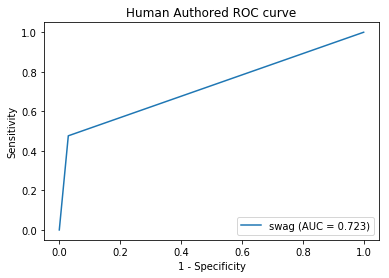

In [28]:
plot_roc_curve(y, yhat,"Human Authored ROC curve", "swag")

In [29]:
metrics.accuracy_score(y,yhat)

0.9624481547649074

In [66]:
len(y)

88254012

In [63]:
thefile = open('human_response.txt', 'w')
for item in y:
    thefile.write("%s\n" % item)

In [65]:
thefile.close()

In [51]:
thefile2 = open('human_prediction.txt', 'w')
for item in yhat:
    thefile2.write("%s\n" % item)
thefile2.close()

In [67]:
len(yhat)

88254012

In [57]:
os.getcwd()

'/home/ubuntu/cs230/HumanBaseline'

In [14]:
df_humanmatrix_real = pd.DataFrame(index = range(60782), columns = comparable_response.columns)

In [16]:
df_humanmatrix_real.shape

(60782, 1452)

In [15]:
list_swag = df_humanmatrix.external_id.tolist()

In [17]:
list_swag

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 

In [18]:
df_humanmatrix_real = pd.DataFrame(list_swag, columns = comparable_response.columns)

In [19]:
df_humanmatrix_real.shape

(60781, 1452)

In [31]:
sum(pd.Series(comparable_response.values.ravel()).isnull())

0

In [24]:
df_humanmatrix_real.to_csv("humanpredict_matrix_real.txt", sep = '\t')

In [32]:
comparable_response.to_csv('comparable_response.txt', sep='\t')

Individual clinical item statistics, finding stats for every column individually

In [36]:
response_names = comparable_response.columns
results = pd.DataFrame(columns = ['Clinical_Item', 'F1_Score', "precision", "recall", "AUROC", "accuracy"])

for response_num in range(1452):
    y_ = comparable_response.iloc[:,response_num]
    yhat = df_humanmatrix_real.iloc[:,response_num]
    bPrecis_, bRecall_, bFscore_, _ = pr(y_, yhat, average='binary')
    results.loc[response_num, 'Clinical_Item'] = response_names[response_num]
    results.loc[response_num, 'F1_Score'] = bFscore_
    results.loc[response_num, 'precision']=bPrecis_
    results.loc[response_num, 'recall'] = bRecall_
    fpr, tpr, _ = metrics.roc_curve(y_,yhat)
    AUROC = metrics.auc(fpr,tpr)
    results.loc[response_num, 'AUROC'] = AUROC
    results.loc[response_num, 'accuracy'] = metrics.accuracy_score(y_,yhat)
    if response_num%100 ==0:
        print "Clinical Item: %s \t results:" % (response_names[response_num])+ str(results.loc[response_num, :])

Clinical Item: RXCUI35302.post.1d 	 results:Clinical_Item    RXCUI35302.post.1d
F1_Score                   0.270073
precision                  0.660714
recall                     0.169725
AUROC                      0.584706
accuracy                   0.996709
Name: 0, dtype: object


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Clinical Item: LABHSVZL.post.1d 	 results:Clinical_Item    LABHSVZL.post.1d
F1_Score                        0
precision                       0
recall                          0
AUROC                         0.5
accuracy                 0.998519
Name: 100, dtype: object


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Clinical Item: IMGNGASTREMP.post.1d 	 results:Clinical_Item    IMGNGASTREMP.post.1d
F1_Score                            0
precision                           0
recall                              0
AUROC                             0.5
accuracy                     0.999622
Name: 200, dtype: object


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Clinical Item: RXCUI7980.post.1d 	 results:Clinical_Item    RXCUI7980.post.1d
F1_Score                         0
precision                        0
recall                           0
AUROC                          0.5
accuracy                   0.99972
Name: 300, dtype: object
Clinical Item: IMGIRDIALRT.post.1d 	 results:Clinical_Item    IMGIRDIALRT.post.1d
F1_Score                           0
precision                          0
recall                             0
AUROC                            0.5
accuracy                     0.99847
Name: 400, dtype: object
Clinical Item: RXCUI31448.post.1d 	 results:Clinical_Item    RXCUI31448.post.1d
F1_Score                          0
precision                         0
recall                            0
AUROC                      0.466162
accuracy                   0.932216
Name: 500, dtype: object
Clinical Item: LABHELAG.post.1d 	 results:Clinical_Item    LABHELAG.post.1d
F1_Score                 0.144487
precision                0.218391
r

In [40]:
results.sort_values("F1_Score", ascending = False)

,Clinical_Item,F1_Score,precision,recall,AUROC,accuracy
1020,LABINSLF.post.1d,0.96875,1,0.939394,0.969697,0.999967
873,CON357.post.1d,0.890966,0.937705,0.848665,0.924175,0.998848
1350,LABIGET.post.1d,0.880702,0.821604,0.94896,0.973576,0.997762
990,LABAFBCF.post.1d,0.826446,0.736498,0.941423,0.969376,0.99689
966,CR131.post.1d,0.821142,0.843468,0.799967,0.891749,0.965203
1110,RXCUI337623.post.1d,0.81307,0.769784,0.861514,0.929427,0.995953
892,PRE6.post.1d,0.812121,0.761364,0.87013,0.934719,0.99898
494,PRE7.post.1d,0.812121,0.761364,0.87013,0.934719,0.99898
891,"RXCUI4850,8591,56443,9863.post.1d",0.808081,0.97561,0.689655,0.844819,0.999687
1072,LABCFRESP.post.1d,0.806754,0.703764,0.945055,0.971027,0.996611


In [41]:
results.to_csv("results_for_humanauthored.txt", sep = '\t')

### list of patient_items from order_sets, and the associated number of items predicted in that order set

In [6]:
response_cols = """
	select 
		distinct ci.name
	from 
		clinical_item as ci,
		clinical_item_category as cic
	where 
		ci.clinical_item_category_id = cic.clinical_item_category_id and
		ci.default_recommend = 1 and
		cic.default_recommend = 1 and
        ci.analysis_status = 1 
"""

In [7]:
df_response_cols = pd.read_sql(response_cols, conn)

In [40]:
df_response_cols.to_csv("response_cols.txt", sep = '\t')

In [9]:
len(df_response_cols)

1452

In [10]:
response_list = ",".join(map(str, df_response_cols.name))
response_list = "(" + response_list + ")"

In [11]:
#select patient_item list with external_id
#then select external_id from these patient item lists and include the tables for ci.name and distinct count ci.name for each external_id from this list

patient_items_num_in_orderset = """
	select 
		ic.external_id,
		pi.patient_item_id
	from 
		item_collection as ic,
		item_collection_item as ici, 
		patient_item_collection_link as picl, 
		patient_item as pi,
		clinical_item as ci,
		clinical_item_category as cic
	where 
		ic.item_collection_id = ici.item_collection_id and
		ici.item_collection_item_id = picl.item_collection_item_id and 
		picl.patient_item_id = pi.patient_item_id and  
		pi.clinical_item_id = ci.clinical_item_id and
		ci.clinical_item_category_id = cic.clinical_item_category_id and
		ci.default_recommend = 1 and
		cic.default_recommend = 1 and
        ci.analysis_status = 1 and
		ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
"""

In [12]:
df_patientitems_orderset_num = pd.read_sql(patient_items_num_in_orderset, conn)

In [13]:
len(df_patientitems_orderset_num)

2540227

In [14]:
all_externalitems_num = """
select 
	ic.external_id,
	count(distinct ci.name)
from 
	item_collection as ic,
	item_collection_item as ici, 
	clinical_item as ci,
	clinical_item_category as cic
where 
	ic.item_collection_id = ici.item_collection_id and
	ici.clinical_item_id = ci.clinical_item_id and
	ci.clinical_item_category_id = cic.clinical_item_category_id and
	ci.default_recommend = 1 and
	cic.default_recommend = 1 and
	ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
group by 
	ic.external_id
"""

In [15]:
df_externalitems_num = pd.read_sql(all_externalitems_num, conn)

In [22]:
df_patientitems_orderset_num["ordersetsize"] = ""

In [24]:
df_externalitems_num["external_id"][0]

522

In [30]:
df_patientitems_orderset_num.drop("ordersetsize", axis = 1, inplace=True)

In [33]:
df_patientitems_final = pd.merge(df_patientitems_orderset_num, df_externalitems_num, on = "external_id")

In [39]:
df_patientitems_final.to_csv("patientitems_num_orderset.txt", sep = '\t')

### get list of patient_item_ids from order sets based on the file delaney sent

In [35]:
data_dir = '/home/ec2-user/cs230/scripts/matrix/final_data_031618_v2/'

In [36]:
fname = data_dir + "final_data_dropcols_"+ str(0) + ".txt"
data = pd.read_table(fname, usecols=[0], sep = '\t', header = 2)

In [37]:
for i in range(1, 15):
    fname = data_dir + "final_data_dropcols_"+ str(i) + ".txt"
    temp = pd.read_table(fname, usecols=[0], sep = '\t', header = 2)
    data = pd.concat([temp, data])

In [38]:
len(data.patient_item_id.unique())

1494917

In [39]:
full_list_patients = pd.read_csv("patientitems_num_orderset.txt", sep = '\t')

IOError: File patientitems_num_orderset_14_notrim.txt does not exist

In [42]:
thelist = data.patient_item_id.tolist()
thefile = open('patient_item_id_list_full_notrim_14.txt', 'w')
for item in thelist:
  thefile.write("%s\n" % item)

In [44]:
patients_from_ordersets_subset = full_list_patients.merge(data, on = "patient_item_id", how = "inner")

In [45]:
len(patients_from_ordersets_subset)

66915

In [46]:
patients_from_ordersets_subset.to_csv("patients_from_ordersets_subset_notrim_14.txt", sep='\t')

## Below are some example Queries
Some interesting facts about the data we have:
There are 2476261 total order_set usages from patient_items out of 55470744 patient_items (4 percent)

In [235]:
 orderSet_overall_usage = """select 
		count(distinct pi.patient_item_id)
	from 
		item_collection as ic,
		item_collection_item as ici, 
		patient_item_collection_link as picl, 
		patient_item as pi,
		clinical_item as ci,
		clinical_item_category as cic
	where 
		ic.item_collection_id = ici.item_collection_id and
		ici.item_collection_item_id = picl.item_collection_item_id and 
		picl.patient_item_id = pi.patient_item_id and  
		pi.clinical_item_id = ci.clinical_item_id and
		ci.clinical_item_category_id = cic.clinical_item_category_id and
		ci.default_recommend = 1 and
		cic.default_recommend = 1 and
		ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
		-- ic.external_id = 692 -- Example for Med Sepsis
        """

In [17]:
total_patient_items = """select count(distinct patient_item_id) from patient_item"""

In [18]:
cursor.execute(total_patient_items)

In [19]:
cursor.fetchall()

[(55470744L,)]

In [236]:
recommend_clinical = """
select 
	count(distinct ci.name)
from 
	clinical_item as ci,
	clinical_item_category as cic
where 
	ci.clinical_item_category_id = cic.clinical_item_category_id and
	ci.default_recommend = 1 and
	cic.default_recommend = 1 and
    ci.analysis_status=1 
"""
cursor.execute(recommend_clinical)
cursor.fetchall()

[(1452L,)]

In [5]:
 orderSetComponentUsage_default = """select 
		ic.external_id,
		ic.name,
		ci.clinical_item_id,
		ci.name,
		ci.description,
		count(distinct pi.patient_item_id) as itemCount
	from 
		item_collection as ic,
		item_collection_item as ici, 
		patient_item_collection_link as picl, 
		patient_item as pi,
		clinical_item as ci,
		clinical_item_category as cic
	where 
		ic.item_collection_id = ici.item_collection_id and
		ici.item_collection_item_id = picl.item_collection_item_id and 
		picl.patient_item_id = pi.patient_item_id and  
		pi.clinical_item_id = ci.clinical_item_id and
		ci.clinical_item_category_id = cic.clinical_item_category_id and
		ci.default_recommend = 1 and
		cic.default_recommend = 1 and
		ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
		-- ic.external_id = 692 -- Example for Med Sepsis
	group by 
		ic.external_id,
		ic.name,
		ci.clinical_item_id,
		ci.name,
		ci.description
        """

In [6]:
cursor.execute(orderSetComponentUsage_default)

In [7]:
cursor.fetchall()

[(522L, 'ED PNEUMONIA', 35733, 'RXCUI2193', 'Ceftriaxone (Intravenous)', 45L),
 (522L,
  'ED PNEUMONIA',
  35849,
  'RXCUI18631',
  'Azithromycin (Intravenous)',
  43L),
 (522L, 'ED PNEUMONIA', 36210, 'RXCUI20481', 'Cefepime (Intravenous)', 19L),
 (522L, 'ED PNEUMONIA', 43997, 'RXCUI11124', 'Vancomycin (Intravenous)', 47L),
 (522L,
  'ED PNEUMONIA',
  44198,
  'RXCUI9863',
  'Sodium Chloride (Intravenous)',
  90L),
 (522L,
  'ED PNEUMONIA',
  44199,
  'RXCUI6915',
  'Metoclopramide (Intravenous)',
  1L),
 (522L, 'ED PNEUMONIA', 44216, 'RXCUI26225', 'Ondansetron (Intravenous)', 12L),
 (522L, 'ED PNEUMONIA', 44221, 'RXCUI161', 'Acetaminophen (Rectal)', 2L),
 (522L,
  'ED PNEUMONIA',
  44237,
  'MED96559',
  'Glucose-Piperacillin-Tazobactam (Intravenous)',
  12L),
 (522L,
  'ED PNEUMONIA',
  44252,
  'MED89444',
  'Glucose-Piperacillin-Tazobactam (Intravenous)',
  1L),
 (522L, 'ED PNEUMONIA', 44281, 'RXCUI161', 'Acetaminophen (Oral)', 10L),
 (522L,
  'ED PNEUMONIA',
  44299,
  'RXCUI82122

In [ ]:
orderSetUsage_Default = """select external_id, name, count(patient_id) as patientCount, 
   avg(itemCount) as avgItemCount, min(itemCount) as minItemCount, max(itemCount) as maxItemCount,
   sum(itemCount) as sumItemCount, sum(itemCount*itemCount) as sumSquaresItemCount
from
(
	select 
		ic.external_id,
		ic.name,
		pi.patient_id,
		count(distinct pi.clinical_item_id) as itemCount
	from 
		item_collection as ic,
		item_collection_item as ici, 
		patient_item_collection_link as picl, 
		patient_item as pi,
		clinical_item as ci,
		clinical_item_category as cic
	where 
		ic.item_collection_id = ici.item_collection_id and
		ici.item_collection_item_id = picl.item_collection_item_id and 
		picl.patient_item_id = pi.patient_item_id and  
		pi.clinical_item_id = ci.clinical_item_id and
		ci.clinical_item_category_id = cic.clinical_item_category_id and
		ci.default_recommend = 1 and
		cic.default_recommend = 1 and
		ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
	group by 
		ic.external_id,
		ic.name,
		pi.patient_id
) as orderSetPatient,
clinical_ite
group by 
	external_id,
	name
"""

In [ ]:
cursor.execute(orderSetUsage_Default)

In [ ]:
cursor.fetchall()

In [ ]:
OrderSetSize_default = """
select 
	ic.external_id,
	ic.name,
	count(distinct ici.clinical_item_id) as itemCount
from 
	item_collection as ic,
	item_collection_item as ici, 
	clinical_item as ci,
	clinical_item_category as cic
where 
	ic.item_collection_id = ici.item_collection_id and
	ici.clinical_item_id = ci.clinical_item_id and
	ci.clinical_item_category_id = cic.clinical_item_category_id and
	ci.default_recommend = 1 and
	cic.default_recommend = 1 and
	ic.section <> 'Ad-hoc Orders' -- Existing option to include orders on the fly, even though they weren't really part of the original order set design / intent
group by 
	ic.external_id,
	ic.name
"""

In [ ]:
cursor.execute(OrderSetSize_default)

In [ ]:
cursor.fetchall()

In [34]:
patients_from_ordersets_subset

,Unnamed: 0,external_id,patient_item_id,count
0,32,1628,16277571,33
1,45,1628,16340851,33
2,75,1628,16463556,33
3,124,1628,16549291,33
4,130,1628,16560282,33
5,175,1628,16636445,33
6,179,1628,16642105,33
7,185,1628,16647817,33
8,189,1628,16651045,33
9,194,1628,16659090,33
